In [1]:
import os
import shutil
import sys
import time

import numpy as np
import copy

from dolfinx import fem, mesh, plot, io, nls
from ufl import dx, ds, grad, inner, exp, sin, diff
import ufl
from mpi4py import MPI
import petsc4py

from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
import pyvista as pv

In [2]:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


def logProg(sequence, every=1):

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)

    for index, record in enumerate(sequence):

        if index % every == 0:
            progress.value = index
        yield record
    progress.value = len(sequence)

In [3]:
dot = Infix(inner)
teta = 0.5
dt = 5.0e-06
lam = 1.0e-02
m = 1

Domain

In [4]:
# domain_mesh = mesh.create_rectangle(
#     comm=MPI.COMM_WORLD,
#     points=((0, 0), (1, 1)),
#     n=(30, 30),
#     cell_type=mesh.CellType.triangle
#     )
domain_mesh = mesh.create_unit_square(
    MPI.COMM_WORLD, 96, 96, mesh.CellType.triangle
    )
base_element = ufl.FiniteElement("Lagrange", domain_mesh.ufl_cell(), 1)
space = fem.FunctionSpace(domain_mesh, base_element * base_element)

Functions

In [5]:
q, v = ufl.TestFunctions(space)

next_func = fem.Function(space)
prew_func = fem.Function(space)

c, mu = ufl.split(next_func)
c0, mu0 = ufl.split(prew_func)

# Initial
next_func.x.array[:] = 0.0
next_func.sub(0).interpolate(
    lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1]))
    )
next_func.x.scatter_forward()     # Don't know it

c = ufl.variable(c)
f = 100 * c**2 * (1 - c)**2
dfdc = diff(f, c)

mu_mid = (1.0-teta) * mu0 + teta*mu

F0 = (c|dot|q) * dx - (c0|dot|q) * dx + m * dt * (grad(mu_mid)|dot|grad(q)) * dx

F1 = (mu|dot|v) * dx - (dfdc|dot|v) * dx - lam * (grad(c)|dot|grad(v)) * dx

F = F0 + F1

In [6]:
# You can't set petsc options right now for nonlinaer problem
problem = fem.petsc.NonlinearProblem(F, next_func)

solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6

ksp = solver.krylov_solver
opts = petsc4py.PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [7]:
file = io.XDMFFile(MPI.COMM_WORLD, 'Chan-Hilliard_file/Chan-Hilliard.xdmf', 'w')
file.write_mesh(domain_mesh)

t = 0.0
T = 10 * dt

c_func = next_func.sub(0)
c_space, c_points = space.sub(0).collapse()

prew_func.x.array[:] = next_func.x.array

time_array = np.arange(0 + dt, T, dt)
middle_time = time_array[len(time_array)*3 // 4]

# for t in logProg(time_array):
#     r = solver.solve(next_func)
#     print(f'Time {t:7.5G} num iterations: {r[0]}')
#     prew_func.x.array[:] = next_func.x.array
#     file.write_function(c_func, t)
#     if t == middle_time: 
#         check_c1 = copy.deepcopy(next_func.x.array[:])
#         print('Checked')


while (t < T):
    t += dt
    r = solver.solve(next_func)
    print(f"Time {t:.0G}: {int(t / dt)} num iterations: {r[0]}")
    prew_func.x.array[:] = next_func.x.array
    file.write_function(c_func, t)
    if int(t / dt) == 5: check_c1 = copy.deepcopy(next_func.x.array);print('Checked')

file.close()

Time 5E-06: 1 num iterations: 3
Time 1E-05: 2 num iterations: 3
Time 2E-05: 3 num iterations: 4
Time 2E-05: 4 num iterations: 4
Time 3E-05: 5 num iterations: 4
Checked
Time 3E-05: 6 num iterations: 5
Time 4E-05: 7 num iterations: 6
Time 4E-05: 8 num iterations: 6
Time 5E-05: 9 num iterations: 5
Time 5E-05: 10 num iterations: 6


### C-plot middle time

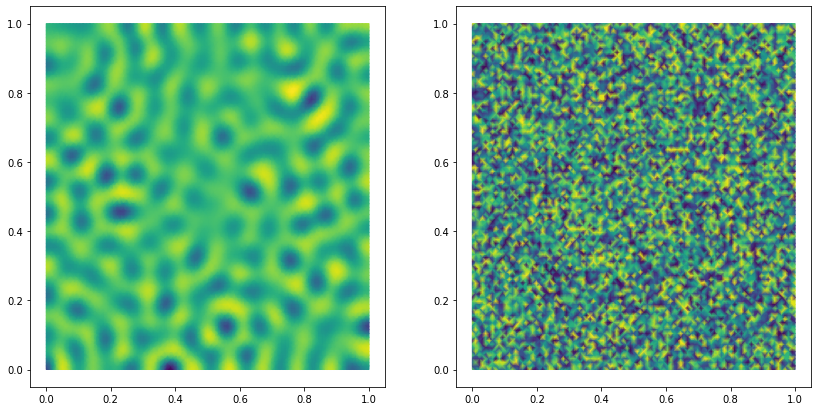

In [8]:
next_func.sub(0).interpolate(
    lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1]))
    )
check_c2 = next_func.sub(0).x.array

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

check_c = check_c1
c_topology, c_cell_types, c_geometry = plot.create_vtk_mesh(c_space)
check_c = np.vstack((np.arange(len(check_c)), check_c)).T[c_points][:, 1]
c_data = np.column_stack((c_geometry[:, 0:2], check_c))
x_data = c_data[:, 0]
y_data = c_data[:, 1]
z_data = c_data[:, 2]
ax[0].tripcolor(x_data, y_data, z_data, shading='gouraud')

check_c = check_c2
c_topology, c_cell_types, c_geometry = plot.create_vtk_mesh(c_space)
check_c = np.vstack((np.arange(len(check_c)), check_c)).T[c_points][:, 1]
c_data = np.column_stack((c_geometry[:, 0:2], check_c))
x_data = c_data[:, 0]
y_data = c_data[:, 1]
z_data = c_data[:, 2]
ax[1].tripcolor(x_data, y_data, z_data, shading='gouraud')

In [9]:
test_func = fem.Function(space)
test_func.sub(0).interpolate(
    lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1]))
    )
test_func.x.array

array([0.62873999, 0.6251674 , 0.62204225, ..., 0.        , 0.63708399,
       0.        ])

In [10]:
test_func2 = fem.Function(space)
test_func2.sub(0).interpolate(
    lambda x: 0.63 + 0.01 * np.where((x[0]**2 + x[1]**2) < 0.3, 1, 0)
    )
test_func2.x.array

array([0.63, 0.63, 0.63, ..., 0.  , 0.63, 0.  ])